Please ensure that you have all necessary packages before running the cell below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# %pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 69.1 MB/s eta 0:00:00


In [4]:
#  %pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 12.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import contextily as ctx
import warnings
import mapclassify
warnings.filterwarnings("ignore")

If you are using google colab, you should be able to directly import all the packages. If it showed errors when importing some packages, you can use " %pip install package-name"

This notebook focuses on the following:
- access feature attributes
- attribute selections
- merge
- spatial join
- choropleth map

When loading the data, make sure you are using the correct path.

In [7]:
#file a: TaxiData.csv
# in the google drive:/content/drive/MyDrive/pyGISData/Data/pt1/Lab2_TaxiData.csv
# in the content folder:/Lab2_TaxiData.csv
taxi_data = pd.read_csv("https://raw.githubusercontent.com/Zoey4222/python-geo-lab/main/data/Lab2_TaxiData.csv", low_memory=False)  # works
taxi_data.head()

,Trip_no,VendorID,PU_hour,DO_hour,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,...,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Trip_type
0,1,2,17,17,N,1,-73.992966,40.697502,-73.989487,40.681534,...,1.55,7.0,1.0,0.5,0.00,0.0,,0.3,8.80,1
1,2,2,17,17,N,1,-73.908485,40.770962,-73.901604,40.749554,...,2.08,9.0,1.0,0.5,0.00,0.0,,0.3,10.80,1
2,3,2,17,17,N,1,-73.986656,40.669422,-73.986557,40.678761,...,2.67,11.0,1.0,0.5,0.00,0.0,,0.3,12.80,1
3,4,1,17,17,N,5,-73.855751,40.693241,-73.855743,40.693241,...,0.60,90.0,0.0,0.0,0.00,0.0,,0.0,90.00,2
4,5,2,17,17,N,1,-73.986526,40.702419,-73.972275,40.694881,...,1.21,6.5,1.0,0.5,1.66,0.0,,0.3,9.96,1


In [8]:
taxi_data.dtypes

,0
Trip_no,int64
VendorID,int64
PU_hour,int64
DO_hour,int64
Store_and_fwd_flag,object
RateCodeID,int64
Pickup_longitude,float64
Pickup_latitude,float64
Dropoff_longitude,float64
Dropoff_latitude,float64


In [9]:
#file b: TaxiPayment.csv
taxi_payment = pd.read_csv('https://raw.githubusercontent.com/Zoey4222/python-geo-lab/refs/heads/main/data/Lab2_TaxiPayment.csv', low_memory=False)
taxi_payment

,Trip_no,Payment_type
0,1,2
1,2,2
2,3,2
3,4,2
4,5,1
...,...,...
11278,11279,2
11279,11280,2
11280,11281,2
11281,11282,2


In [10]:
taxi_payment.dtypes

,0
Trip_no,int64
Payment_type,int64


Now let's create a point layer based on the dropoff locations (i.e., coordinates) in the taxi_data df

In [11]:
taxi_data_gdf = gpd.GeoDataFrame(taxi_data, geometry=gpd.points_from_xy(taxi_data['Dropoff_longitude'], taxi_data['Dropoff_latitude']), crs='EPSG:4326')

In [12]:
#check some statistics of the 'Total_amount' column
taxi_data_gdf['Total_amount'].describe()

,Total_amount
count,11283.000000
mean,14.401081
std,10.185821
min,-35.000000
25%,8.760000
50%,11.300000
75%,16.620000
max,303.800000


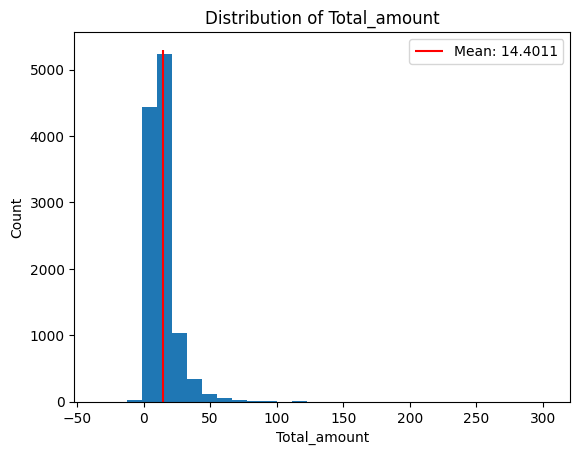

In [13]:
#visualize the distribution of this col
plt.hist(taxi_data_gdf['Total_amount'], bins=30)
#add a vertical line for the mean
tot_amount_mean = round(taxi_data_gdf['Total_amount'].mean(), 4)
plt.vlines(tot_amount_mean, ymin=0, ymax=5300, color='red', label=f'Mean: {tot_amount_mean}')
#customization
plt.xlabel('Total_amount')
plt.ylabel('Count')
plt.title('Distribution of Total_amount')
#show legend
plt.legend()

In [14]:
#now only select rows whose Total_amount is greater than 0, and Trip_distance is greater than 0
#use .loc and necessary conditions, as shown below
#save as new variable
#&: and
#|: or
#here, we want the "and" logic
taxi_data_gdf_1 = taxi_data_gdf.loc[(taxi_data_gdf['Total_amount']>0) & (taxi_data_gdf['Trip_distance']>0)]
taxi_data_gdf_1.shape

(11151, 22)

As seen in the output above, we reduced the number of rows from 11283 to 11151.

<Axes: >

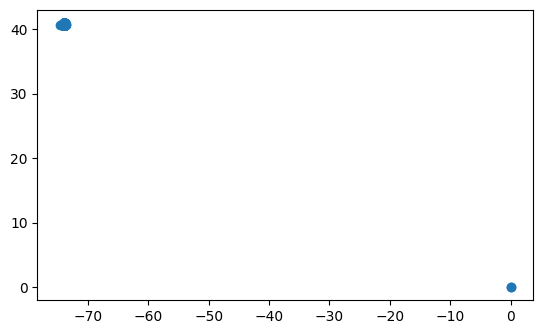

In [15]:
#preliminary visualization
taxi_data_gdf_1.plot()

The above seems a bit weird. We should remove the point(s) that are at (0,0)

In [16]:
taxi_data_gdf_2 =  taxi_data_gdf_1.loc[(taxi_data_gdf_1['Dropoff_longitude']!=0) & (taxi_data_gdf['Dropoff_latitude']!=0)]
taxi_data_gdf_2.shape

(11149, 22)

<Axes: >

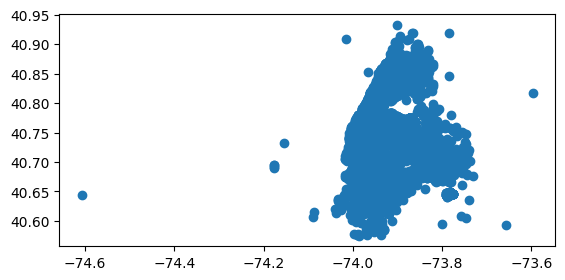

In [17]:
taxi_data_gdf_2.plot()

Now let's join the taxi_payment df to the taxi_data_gdf_2 using an unique identifier.

In [18]:
taxi_data_merged = taxi_data_gdf_2.merge(taxi_payment, how='left')
taxi_data_merged.columns

Index(['Trip_no', 'VendorID', 'PU_hour', 'DO_hour', 'Store_and_fwd_flag',
       'RateCodeID', 'Pickup_longitude', 'Pickup_latitude',
       'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count',
       'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount',
       'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount',
       'Trip_type', 'geometry', 'Payment_type'],
      dtype='object')

Our next step is to perform spatial join, in which our desired output is to have the number of trips at the neighborhood level.

In [19]:
nta = gpd.read_file('https://raw.githubusercontent.com/Zoey4222/python-geo-lab/main/data/Neighborhood%20Tabulation%20Areas/geo_export_bb0720e0-e8ac-4320-8198-4d92d6d7ce2f.shp').to_crs(4326) #match the crs of the polygon layer to the point layer we created
nta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
len(nta)


195

In [21]:
#first use .sjoin() to get to a gdf where each trip is associated with one nta
#use inner join to ensure the output only includes intersected points
taxi_nta = gpd.sjoin(taxi_data_merged, nta, how='inner')
#sanity check: shouldn't have any nans
print(sum(taxi_nta.isna().sum()))
#now group by nta to get to the number of trips per nta
trips_count = taxi_nta.groupby(['ntaname'], as_index=False).agg({'Trip_no':'count'})
print(len(trips_count))

0
173


In [22]:
#now map the trip count back to nta for plotting
trips_nta = dict(trips_count.values.tolist())
nta['trips'] = nta['ntaname'].map(trips_nta)
#make sure to drop nan rows based on the trips column
nta_1 = nta.dropna(subset=['trips'])
print(nta_1.shape)
nta_1.head()

(173, 9)


,ntacode,ntaname,boro_name,shape_leng,county_fip,shape_area,boro_code,geometry,trips
0,BK88,Borough Park,Brooklyn,39247.228028,047,5.400502e+07,3.0,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",9.0
1,QN52,East Flushing,Queens,25843.364934,081,2.945438e+07,4.0,"POLYGON ((-73.79493 40.7578, -73.79475 40.7556...",7.0
3,QN51,Murray Hill,Queens,33266.904732,081,5.248828e+07,4.0,"POLYGON ((-73.80379 40.77561, -73.80099 40.775...",17.0
4,QN27,East Elmhurst,Queens,19816.712116,081,1.972685e+07,4.0,"POLYGON ((-73.8611 40.76366, -73.85993 40.7622...",61.0
5,BX35,Morrisania-Melrose,Bronx,27740.845668,005,1.689175e+07,2.0,"POLYGON ((-73.89697 40.83434, -73.89679 40.834...",29.0


Now we can create a choropleth map to show the number of trips per NTA using the output above.

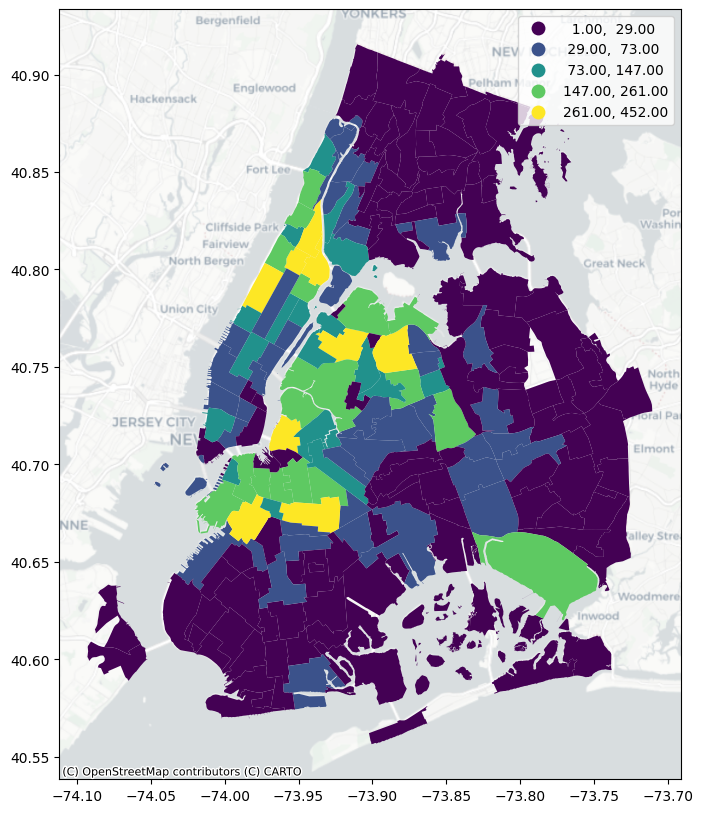

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
nta_1.plot(column='trips', ax=ax, legend=True, cmap='viridis', scheme='natural_breaks')
ctx.add_basemap(ax=ax, crs=4326, source=ctx.providers.CartoDB.Positron,alpha=0.9)

The result above is similar to the output in ArcGIS shown in the previous tutorial, aside from removing NTAs with no interesected trip point data.